# Deblurring model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D
from sklearn.model_selection import train_test_split


input data

In [2]:
good_frames = 'data/dataset/train/normal'
bad_frames = 'data/w_remove_dataset'

In [3]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

100%|██████████| 1731/1731 [00:02<00:00, 632.09it/s]


In [4]:
seed = 21
random.seed = seed
np.random.seed = seed

In [5]:
x = clean_frames;
y = blurry_frames;
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


## Affichage d'une image originale avec celle résultant du modèle de remove watermarks

390


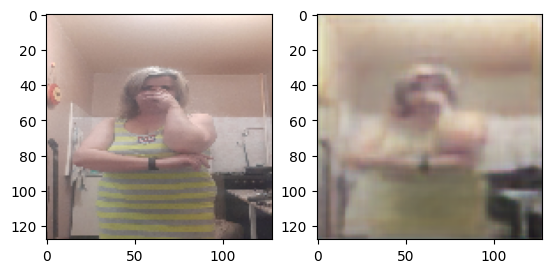

In [7]:
r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

# AI de deblurring

In [8]:
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

layer_filters = [64, 128, 256]

In [9]:
inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

In [10]:
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = x.shape
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

2024-12-18 15:35:53.139015: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2024-12-18 15:35:53.139055: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-18 15:35:53.139072: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-18 15:35:53.139113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-18 15:35:53.139128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### encoder

In [11]:
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_vector (Dense)           │ (None, 256)            │    16,777,472 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,148,288 (65.42 MB)

 Trainable params: 17,148,288 (65.42 MB)

 Non-trainable params: 0 (0.00 B)

### decoder

In [12]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

In [13]:
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 65536)          │    16,842,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output                  │ (None, 128, 128, 3)    │         1,731 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,803,395 (67.91 MB)

 Trainable params: 17,803,395 (67.91 MB)

 Non-trainable params: 0 (0.00 B)

### autoencoder

In [14]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 256)            │    17,148,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 128, 128, 3)    │    17,803,395 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,951,683 (133.33 MB)

 Trainable params: 34,951,683 (133.33 MB)

 Non-trainable params: 0 (0.00 B)

## Autoencoder training

In [15]:
autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

In [16]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

In [17]:
callbacks = [lr_reducer]
history = autoencoder.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks)

Epoch 1/100


2024-12-18 15:35:53.994442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - acc: 0.6517 - loss: 0.0630 - val_acc: 0.6900 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - acc: 0.6895 - loss: 0.0365 - val_acc: 0.6899 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 315ms/step - acc: 0.6897 - loss: 0.0271 - val_acc: 0.6921 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 311ms/step - acc: 0.6934 - loss: 0.0229 - val_acc: 0.6950 - val_loss: 0.0209 - learning_rate: 0.0010
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - acc: 0.6952 - loss: 0.0206 - val_acc: 0.6943 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 316ms/step - acc: 0.6880 - loss: 0.0192 - val_acc: 0.6713 - val_loss: 0.0183 - learning_rate: 0.0010
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - acc: 0.6858 - loss: 0.0178 - val_acc: 0.6894 - val_loss: 0.0165 - learning_rate: 0.0010
Epoc

In [22]:
# Sauvegarder tout le modèle
autoencoder.save("autoencoder_model.keras")

# Visualisation


       Input                        Ground Truth                  Predicted Value
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


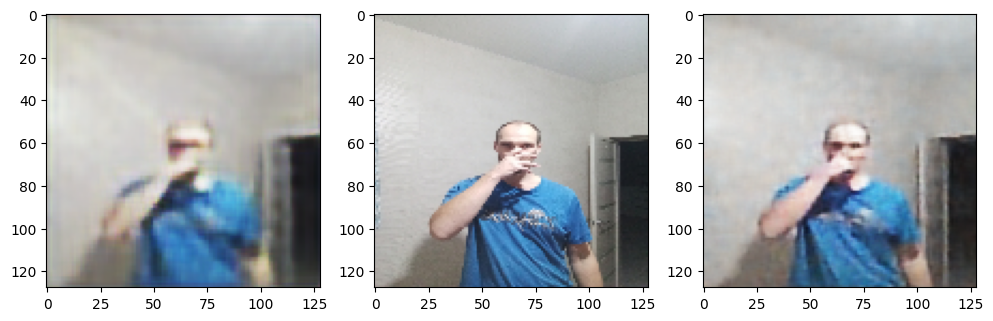

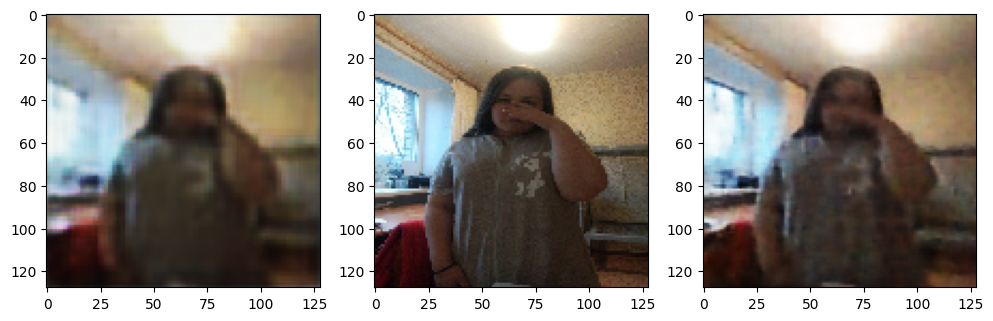

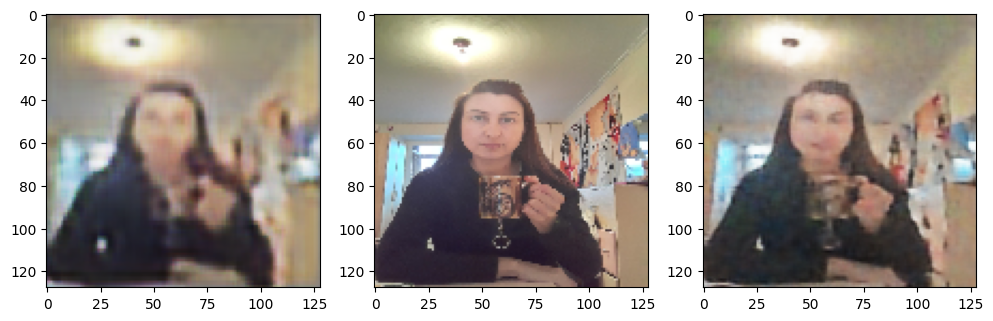

In [18]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):
    
    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

# Stats

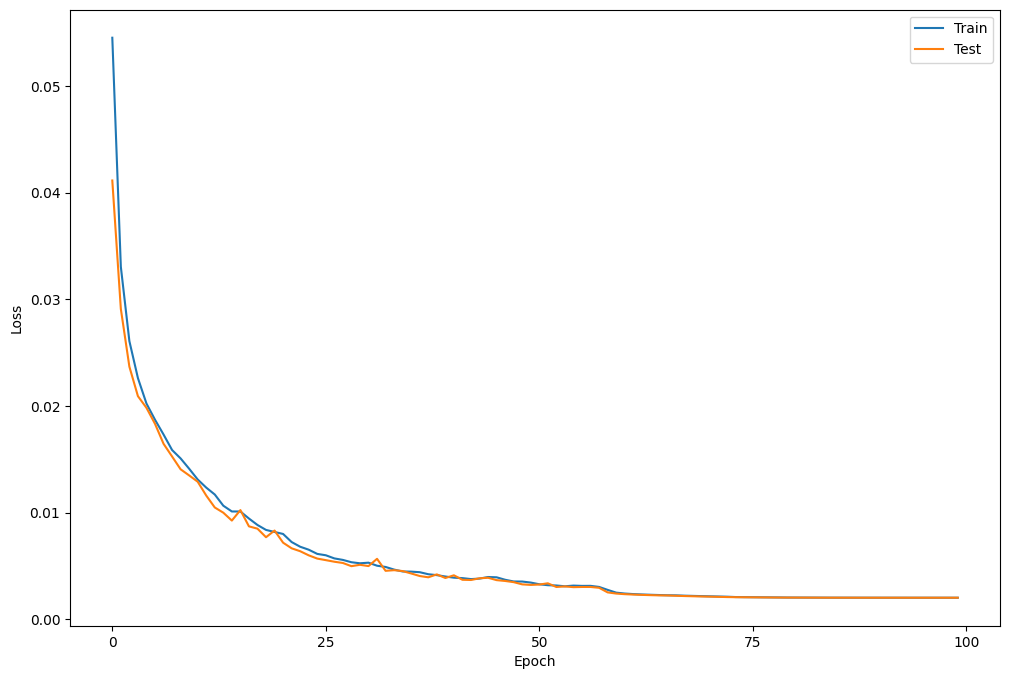

In [19]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, 101, 25))
plt.show()

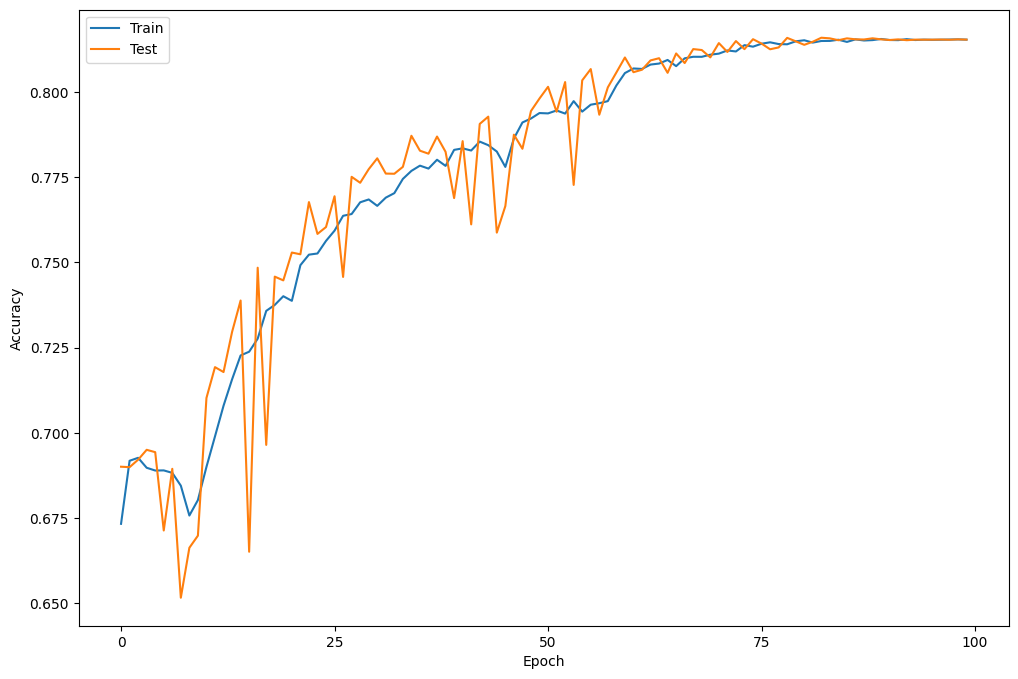

In [20]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, 101, 25))
plt.show()